In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import collections
import torch.optim as optim
# from gensim.models import KeyedVectors
# import gensim.downloader as api
import pickle
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from utils.preprocess import *
from utils.test import * 
from utils.train import * 
from utils.crossval import CrossValidation
from custom_data.dataset import *
from models.vanilla_rnn import RNN_Classifier
from models.gru import GRUClassifier
from models.lstm import LSTMClassifier
import numpy as np



c:\Users\saidy\anaconda3\envs\RNNenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\saidy\anaconda3\envs\RNNenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
dataset = load_dataset("ag_news")
dataset["train"].to_csv("train.csv")
dataset["test"].to_csv("test.csv")

Creating CSV from Arrow format: 100%|██████████| 8/8 [00:00<00:00, 173.89ba/s]


1830309

### Inspect Data

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("train shape: ", df_train.shape)
print("test shape ", df_test.shape)

train shape:  (120000, 2)
test shape  (7600, 2)


### Check for Null Values/Duplicates

In [4]:
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

print("train shape: ", df_train.shape)
print("test shape ", df_test.shape)

train shape:  (120000, 2)
test shape  (7600, 2)


### Check Class Balance

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


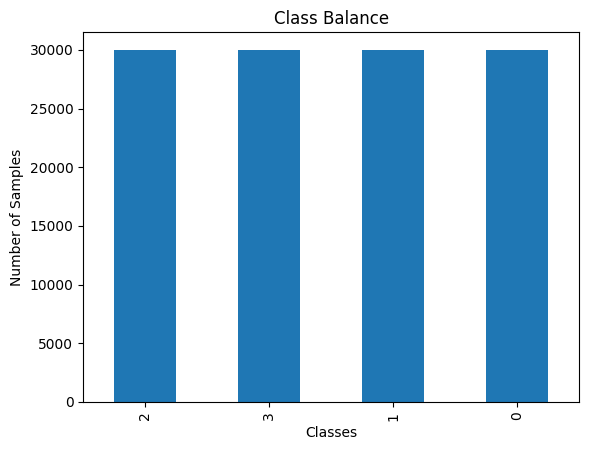

In [5]:
class_balance = df_train['label'].value_counts() ## count for each class the nuumber of samples

print(class_balance)

ax = class_balance.plot(kind='bar')
ax.set_title("Class Balance")
ax.set_xlabel("Classes")
ax.set_ylabel("Number of Samples")

plt.show()

### Add Category Column for Readability

In [6]:
dataset['train'].features['label']

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])

In [7]:
labels = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
df_train['Category'] = df_train['label'].map(labels)
df_test['Category'] = df_test['label'].map(labels)
df_train.head(5)

,text,label,Category
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


### World Cloud Visualization for Most Frequent Words

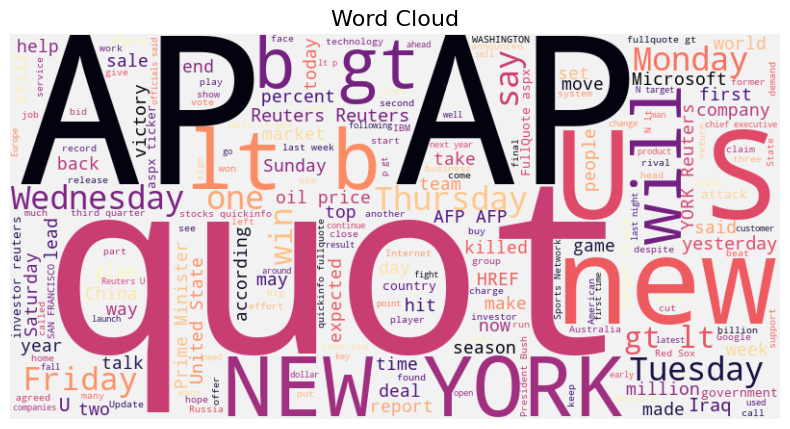

In [8]:
all_descriptions = ' '.join(df_train['text'].values)
cloud(all_descriptions, "Word Cloud", colormap='magma', background_color='#f2f2f2')

### Preprocessing Data

##### Handling Contractions

In [9]:
df_train['text'] = df_train['text'].apply(lambda x: decontract_words(x))
df_test['text'] = df_test['text'].apply(lambda x: decontract_words(x))

##### Handling Unwanted Characters

In [10]:
df_train['text'] = df_train['text'].apply(lambda x: format_text_regex(x))
df_test['text'] = df_test['text'].apply(lambda x: format_text_regex(x))

##### Tokenization

In [11]:
df_train['tokens'] = df_train['text'].apply(nltk.word_tokenize)
df_test['tokens'] = df_test['text'].apply(nltk.word_tokenize)

##### Stop Words

In [12]:
df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))

##### Stemming

In [13]:
df_train['stemmed_text'] = df_train['tokens'].apply(stem_words)
df_test['stemmed_text'] = df_test['tokens'].apply(lambda x: stem_words(x))

##### Lemmitization

In [15]:
# df_train['lemmatized_text'] = df_train['tokens'].apply(lemmatize_passage)
# df_test['lemmatized_text'] = df_test['tokens'].apply(lambda x: lemmatize_passage(x))
df_train.head(5)

,text,label,Category,tokens,stemmed_text
0,Wall St Bears Claw Back Into Black Reuters Reu...,2,Business,"[Wall, St, Bears, Claw, Back, Into, the, Black...","[wall, st, bear, claw, back, into, the, black,..."
1,Carlyle Looks Toward Commercial Aerospace Reut...,2,Business,"[Carlyle, Looks, Toward, Commercial, Aerospace...","[carlyl, look, toward, commerci, aerospac, reu..."
2,Oil Economy Cloud Stocks Outlook Reuters Reute...,2,Business,"[Oil, and, Economy, Cloud, Stocks, Outlook, Re...","[oil, and, economi, cloud, stock, outlook, reu..."
3,Iraq Halts Oil Exports Main Southern Pipeline ...,2,Business,"[Iraq, Halts, Oil, Exports, from, Main, Southe...","[iraq, halt, oil, export, from, main, southern..."
4,Oil prices soar time record posing new menace ...,2,Business,"[Oil, prices, soar, to, all, time, record, pos...","[oil, price, soar, to, all, time, record, pose..."


### Creating Vocab + Encoding <BR>
REFERNCES: <BR>
[build vocab](https://medium.com/@jainilgosalia/building-an-rnn-for-sentiment-analysis-with-pytorch-5b80d9142bb8) <br>
[encode and pad](https://www.geeksforgeeks.org/deep-learning/implementing-recurrent-neural-networks-in-pytorch/)

In [14]:
vocab = {word for phrase in df_train['stemmed_text'] for word in phrase}
vocab_size = len(vocab) + 2

word_to_idx = {word: idx for idx, word in enumerate(vocab, start=2)}  

max_length = df_train['stemmed_text'].apply(len).max()

df_train['encoded'] = df_train['stemmed_text'].apply(lambda x: encode_and_pad(x, word_to_idx, max_length))
df_test['encoded'] = df_test['stemmed_text'].apply(lambda x: encode_and_pad(x, word_to_idx, max_length))


with open("assets/word_to_idx.pkl", "wb") as f:
    pickle.dump(word_to_idx, f)

with open("assets/max_length.pkl", "wb") as f:
    pickle.dump(max_length, f)

with open("assets/vocab_size.pkl", "wb") as f:
    pickle.dump(vocab_size, f)


df_train.head(5)

,text,label,Category,tokens,stemmed_text,encoded
0,Wall St Bears Claw Back Into Black Reuters Reu...,2,Business,"[Wall, St, Bears, Claw, Back, Into, the, Black...","[wall, st, bear, claw, back, into, the, black,...","[36168, 35938, 8284, 52697, 26894, 46044, 4438..."
1,Carlyle Looks Toward Commercial Aerospace Reut...,2,Business,"[Carlyle, Looks, Toward, Commercial, Aerospace...","[carlyl, look, toward, commerci, aerospac, reu...","[42441, 47767, 13679, 43042, 32379, 17398, 173..."
2,Oil Economy Cloud Stocks Outlook Reuters Reute...,2,Business,"[Oil, and, Economy, Cloud, Stocks, Outlook, Re...","[oil, and, economi, cloud, stock, outlook, reu...","[11605, 19594, 9472, 42966, 40573, 9471, 17398..."
3,Iraq Halts Oil Exports Main Southern Pipeline ...,2,Business,"[Iraq, Halts, Oil, Exports, from, Main, Southe...","[iraq, halt, oil, export, from, main, southern...","[5843, 49973, 11605, 39924, 5859, 8122, 45266,..."
4,Oil prices soar time record posing new menace ...,2,Business,"[Oil, prices, soar, to, all, time, record, pos...","[oil, price, soar, to, all, time, record, pose...","[11605, 7753, 51614, 17002, 16176, 44813, 1783..."


### Using Custom Data Class and Preparing Loaders

In [15]:
train_dataset = AGNewsDataset(df_train)
test_dataset = AGNewsDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Device

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Vanilla RNN with Glove Embedding

In [17]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-100') # load glove model

##### Create Embedding Matrix to match words in vocab to embeddings from glove

In [18]:
embedding_dim = 100 ## embedding dimension of glove model 

#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

embedding_matrix = np.zeros((len(word_to_idx) + 2, embedding_dim)) 
for word, i in word_to_idx.items():
    if word in glove_model:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

#create the layer to use in model
embedding_layer = nn.Embedding.from_pretrained(embeddings=embedding_tensor,freeze=False,padding_idx=0) ## freeze so weights dont get updated

##reference: https://stackoverflow.com/questions/49710537/pytorch-gensim-how-do-i-load-pre-trained-word-embeddings?utm_source=chatgpt.com
#https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html


##### Train

In [19]:
hidden_dim = 128
num_classes = 4
batch_size = 64
epochs = 10
learning_rate = 0.001
embed_dim = 100

RNN_glove_model = RNN_Classifier(embedding_layer, hidden_dim=hidden_dim, num_class=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(RNN_glove_model.parameters(), lr=learning_rate)

train_model(RNN_glove_model, train_loader, train_dataset, loss_fn, optimizer, device, epochs)



Epoch 1/10 - Loss: 0.6019 - Accuracy: 0.8115
Epoch 2/10 - Loss: 0.2703 - Accuracy: 0.9133
Epoch 3/10 - Loss: 0.2259 - Accuracy: 0.9277
Epoch 4/10 - Loss: 0.2003 - Accuracy: 0.9345
Epoch 5/10 - Loss: 0.1757 - Accuracy: 0.9418
Epoch 6/10 - Loss: 0.1617 - Accuracy: 0.9459
Epoch 7/10 - Loss: 0.1605 - Accuracy: 0.9474
Epoch 8/10 - Loss: 0.1573 - Accuracy: 0.9489
Epoch 9/10 - Loss: 0.1321 - Accuracy: 0.9553
Epoch 10/10 - Loss: 0.1232 - Accuracy: 0.9582


##### Save Model

In [39]:
torch.save(RNN_glove_model.state_dict(), "assets/RNN_Classifier.pt")

##### Test

In [20]:
evaluate_model(RNN_glove_model,test_loader, test_dataset, device)

Test Accuracy: 0.9003
F1 Score: 0.9001


(0.9002631578947369, 0.9001482191277065)

Cross Validation

In [21]:
cross_val = CrossValidation(train_dataset, n_splits=5)
mean_accuracy, std_accuracy = cross_val.run(RNN_Classifier, 5,learning_rate, device, vocab, embed_dim,  hidden_dim, embedding_layer)
print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

Epoch 1/5 - Loss: 0.8353 - Accuracy: 0.6895
Epoch 2/5 - Loss: 0.5222 - Accuracy: 0.8545
Epoch 3/5 - Loss: 0.3358 - Accuracy: 0.9130
Epoch 4/5 - Loss: 0.3423 - Accuracy: 0.8981
Epoch 5/5 - Loss: 0.3387 - Accuracy: 0.9010
Validation Accuracy: 0.8887
Epoch 1/5 - Loss: 0.5555 - Accuracy: 0.8162
Epoch 2/5 - Loss: 0.3415 - Accuracy: 0.9140
Epoch 3/5 - Loss: 0.1912 - Accuracy: 0.9397
Epoch 4/5 - Loss: 0.1730 - Accuracy: 0.9451
Epoch 5/5 - Loss: 0.1430 - Accuracy: 0.9523
Validation Accuracy: 0.9398
Epoch 1/5 - Loss: 0.5812 - Accuracy: 0.8345
Epoch 2/5 - Loss: 0.4411 - Accuracy: 0.8765
Epoch 3/5 - Loss: 0.3048 - Accuracy: 0.9209
Epoch 4/5 - Loss: 0.2149 - Accuracy: 0.9373
Epoch 5/5 - Loss: 0.1702 - Accuracy: 0.9457
Validation Accuracy: 0.9403
Epoch 1/5 - Loss: 0.4039 - Accuracy: 0.8851
Epoch 2/5 - Loss: 0.4303 - Accuracy: 0.8928
Epoch 3/5 - Loss: 0.3822 - Accuracy: 0.9145
Epoch 4/5 - Loss: 0.2073 - Accuracy: 0.9375
Epoch 5/5 - Loss: 0.1642 - Accuracy: 0.9473
Validation Accuracy: 0.9325
Epoch 1/

##### Grid Search

In [ ]:
hyperparameters = {
    'embed_dim': [50, 100],
    'hidden_dim': [64, 128],
    'lr': [0.01, 0.001],
    'epochs': [5] # should be 5 or 10, and 10 will definetly be better, but for faster testing we use 5.
}
best_accuracy = 0
RNN_best_params = None

for embed_dim in hyperparameters['embed_dim']:
    for hidden_dim in hyperparameters['hidden_dim']:
        for lr in hyperparameters['lr']:
            for epochs in hyperparameters['epochs']:
                print(f"Embed_dim={embed_dim}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")
                mean_accuracy, std_accuracy = cross_val.run(RNN_Classifier, 5,learning_rate, device, vocab,embed_dim,  hidden_dim, embedding_layer)
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    RNN_best_params = {
                        'embed_dim': embed_dim,
                        'hidden_dim': hidden_dim,
                        'lr': lr,
                        'epochs': epochs
                    }
                print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")
print(f"Best Hyperparameters: {RNN_best_params}, Best Accuracy: {best_accuracy:.4f}")

with open("assets/RNN_best_params.pkl", "wb") as f:
    pickle.dump(RNN_best_params, f)

Embed_dim=50, hidden_dim=64, lr=0.01, epochs=5
Epoch 1/10 - Loss: 0.3380 - Accuracy: 0.9128
Epoch 2/10 - Loss: 0.2058 - Accuracy: 0.9291
Epoch 3/10 - Loss: 0.2098 - Accuracy: 0.9299
Epoch 4/10 - Loss: 0.2232 - Accuracy: 0.9248
Epoch 5/10 - Loss: 0.2053 - Accuracy: 0.9289
Epoch 6/10 - Loss: 0.2017 - Accuracy: 0.9310
Epoch 7/10 - Loss: 0.1965 - Accuracy: 0.9318
Epoch 8/10 - Loss: 0.2020 - Accuracy: 0.9299
Epoch 9/10 - Loss: 0.1895 - Accuracy: 0.9335
Epoch 10/10 - Loss: 0.1851 - Accuracy: 0.9364
Validation Accuracy: 0.9289
Epoch 1/10 - Loss: 0.2065 - Accuracy: 0.9297
Epoch 2/10 - Loss: 0.2035 - Accuracy: 0.9293
Epoch 3/10 - Loss: 0.2073 - Accuracy: 0.9286
Epoch 4/10 - Loss: 0.2218 - Accuracy: 0.9251
Epoch 5/10 - Loss: 0.2385 - Accuracy: 0.9202
Epoch 6/10 - Loss: 0.2177 - Accuracy: 0.9243
Epoch 7/10 - Loss: 0.2167 - Accuracy: 0.9255
Epoch 8/10 - Loss: 0.2170 - Accuracy: 0.9258
Epoch 9/10 - Loss: 0.2138 - Accuracy: 0.9270
Epoch 10/10 - Loss: 0.2095 - Accuracy: 0.9279
Validation Accuracy: 0.

### LSTM Model

##### Train

In [22]:
vocab_size = len(vocab) + 2  
embed_dim = 100
hidden_dim = 128
output_dim = 4  

LSTM_model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim).to(device)

lr2 = 0.01
loss2_fn = torch.nn.CrossEntropyLoss()
optimizer2 = optim.Adam(LSTM_model.parameters(), lr= lr2)
loss2_fn = loss2_fn.to(device)
epochs= 10

train_model(LSTM_model, train_loader, train_dataset, loss2_fn, optimizer2, device, epochs)


Epoch 1/10 - Loss: 0.3539 - Accuracy: 0.8796
Epoch 2/10 - Loss: 0.2150 - Accuracy: 0.9293
Epoch 3/10 - Loss: 0.1822 - Accuracy: 0.9382
Epoch 4/10 - Loss: 0.1685 - Accuracy: 0.9423
Epoch 5/10 - Loss: 0.1610 - Accuracy: 0.9449
Epoch 6/10 - Loss: 0.1575 - Accuracy: 0.9456
Epoch 7/10 - Loss: 0.1571 - Accuracy: 0.9461
Epoch 8/10 - Loss: 0.1540 - Accuracy: 0.9462
Epoch 9/10 - Loss: 0.1507 - Accuracy: 0.9476
Epoch 10/10 - Loss: 0.1485 - Accuracy: 0.9484


##### Save Model

In [43]:
torch.save(LSTM_model.state_dict(), "assets/LSTM_Classifier.pt")

##### Test

In [23]:
evaluate_model(LSTM_model,test_loader, test_dataset, device)

Test Accuracy: 0.8992
F1 Score: 0.8991


(0.8992105263157895, 0.899079362527018)

##### Cross-Val

In [24]:
cross_val = CrossValidation(train_dataset, n_splits=5)
mean_accuracy, std_accuracy = cross_val.run(LSTMClassifier, 5,learning_rate, device, vocab,embed_dim,  hidden_dim)
print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

Epoch 1/5 - Loss: 0.6316 - Accuracy: 0.7555
Epoch 2/5 - Loss: 0.3016 - Accuracy: 0.9002
Epoch 3/5 - Loss: 0.2327 - Accuracy: 0.9233
Epoch 4/5 - Loss: 0.1906 - Accuracy: 0.9373
Epoch 5/5 - Loss: 0.1533 - Accuracy: 0.9502
Validation Accuracy: 0.9100
Epoch 1/5 - Loss: 0.6622 - Accuracy: 0.7301
Epoch 2/5 - Loss: 0.3036 - Accuracy: 0.8991
Epoch 3/5 - Loss: 0.2317 - Accuracy: 0.9242
Epoch 4/5 - Loss: 0.1847 - Accuracy: 0.9389
Epoch 5/5 - Loss: 0.1469 - Accuracy: 0.9516
Validation Accuracy: 0.9095
Epoch 1/5 - Loss: 0.6756 - Accuracy: 0.7309
Epoch 2/5 - Loss: 0.3022 - Accuracy: 0.9008
Epoch 3/5 - Loss: 0.2297 - Accuracy: 0.9254
Epoch 4/5 - Loss: 0.1826 - Accuracy: 0.9402
Epoch 5/5 - Loss: 0.1435 - Accuracy: 0.9539
Validation Accuracy: 0.9097
Epoch 1/5 - Loss: 0.6672 - Accuracy: 0.7274
Epoch 2/5 - Loss: 0.3116 - Accuracy: 0.8962
Epoch 3/5 - Loss: 0.2378 - Accuracy: 0.9224
Epoch 4/5 - Loss: 0.1893 - Accuracy: 0.9382
Epoch 5/5 - Loss: 0.1514 - Accuracy: 0.9504
Validation Accuracy: 0.9092
Epoch 1/

##### Grid Search

In [ ]:
hyperparameters = {
    'embed_dim': [50, 100],
    'hidden_dim': [64, 128],
    'lr': [0.01, 0.001],
    'epochs': [5] # should be 5 or 10, and 10 will definetly be better, but for faster testing we use 5.
}
best_accuracy = 0
LSTM_best_params = None

for embed_dim in hyperparameters['embed_dim']:
    for hidden_dim in hyperparameters['hidden_dim']:
        for lr in hyperparameters['lr']:
            for epochs in hyperparameters['epochs']:
                print(f"Embed_dim={embed_dim}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")
                mean_accuracy, std_accuracy = cross_val.run(LSTMClassifier, 5,learning_rate, device, vocab,embed_dim,  hidden_dim)
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    LSTM_best_params = {
                        'embed_dim': embed_dim,
                        'hidden_dim': hidden_dim,
                        'lr': lr,
                        'epochs': epochs
                    }
                print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")
print(f"Best Hyperparameters: {LSTM_best_params}, Best Accuracy: {best_accuracy:.4f}")

with open("assets/LSTM_best_params.pkl", "wb") as f:
    pickle.dump(LSTM_best_params, f)

Embed_dim=50, hidden_dim=64, lr=0.01, epochs=5
Epoch 1/10 - Loss: 0.0849 - Accuracy: 0.9702
Epoch 2/10 - Loss: 0.0726 - Accuracy: 0.9744
Epoch 3/10 - Loss: 0.0674 - Accuracy: 0.9764
Epoch 4/10 - Loss: 0.0652 - Accuracy: 0.9768
Epoch 5/10 - Loss: 0.0620 - Accuracy: 0.9780
Epoch 6/10 - Loss: 0.0602 - Accuracy: 0.9787
Epoch 7/10 - Loss: 0.0590 - Accuracy: 0.9786
Epoch 8/10 - Loss: 0.0577 - Accuracy: 0.9796
Epoch 9/10 - Loss: 0.0550 - Accuracy: 0.9801
Epoch 10/10 - Loss: 0.0540 - Accuracy: 0.9808
Validation Accuracy: 0.9489
Epoch 1/10 - Loss: 0.0852 - Accuracy: 0.9711
Epoch 2/10 - Loss: 0.0723 - Accuracy: 0.9748
Epoch 3/10 - Loss: 0.0658 - Accuracy: 0.9768
Epoch 4/10 - Loss: 0.0620 - Accuracy: 0.9780
Epoch 5/10 - Loss: 0.0591 - Accuracy: 0.9794
Epoch 6/10 - Loss: 0.0554 - Accuracy: 0.9802
Epoch 7/10 - Loss: 0.0535 - Accuracy: 0.9810
Epoch 8/10 - Loss: 0.0533 - Accuracy: 0.9810
Epoch 9/10 - Loss: 0.0535 - Accuracy: 0.9809
Epoch 10/10 - Loss: 0.0533 - Accuracy: 0.9808
Validation Accuracy: 0.

### GRU Model

##### Train

In [28]:
vocab_size = len(vocab) + 2
embed_dim = 50
hidden_dim = 128
output_dim = 4

gru_model = GRUClassifier(vocab_size, embed_dim, hidden_dim, output_dim).to(device)

learning_rate = 0.001
num_epochs = 10
optimizer3 = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
loss3_fn = torch.nn.CrossEntropyLoss()
loss3_fn = loss3_fn.to(device)

train_model(gru_model, train_loader, train_dataset, loss3_fn, optimizer3, device, num_epochs)


Epoch 1/10 - Loss: 0.5283 - Accuracy: 0.7933
Epoch 2/10 - Loss: 0.2741 - Accuracy: 0.9079
Epoch 3/10 - Loss: 0.2148 - Accuracy: 0.9273
Epoch 4/10 - Loss: 0.1703 - Accuracy: 0.9426
Epoch 5/10 - Loss: 0.1342 - Accuracy: 0.9549
Epoch 6/10 - Loss: 0.1015 - Accuracy: 0.9660
Epoch 7/10 - Loss: 0.0758 - Accuracy: 0.9745
Epoch 8/10 - Loss: 0.0562 - Accuracy: 0.9813
Epoch 9/10 - Loss: 0.0409 - Accuracy: 0.9864
Epoch 10/10 - Loss: 0.0323 - Accuracy: 0.9892


##### Save Model

In [29]:
torch.save(gru_model.state_dict(), "assets/GRU_Classifier.pt")

##### Test

In [18]:
evaluate_model(gru_model,test_loader, test_dataset, device)

Test Accuracy: 0.9008
F1 Score: 0.9007


(0.9007894736842105, 0.9006841430307634)

##### Cross-Val

In [19]:
cross_val = CrossValidation(train_dataset, n_splits=5)
mean_accuracy, std_accuracy = cross_val.run(GRUClassifier, 5,learning_rate, device, vocab,embed_dim,  hidden_dim)
print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

Epoch 1/5 - Loss: 0.4971 - Accuracy: 0.8093
Epoch 2/5 - Loss: 0.2561 - Accuracy: 0.9152
Epoch 3/5 - Loss: 0.1928 - Accuracy: 0.9360
Epoch 4/5 - Loss: 0.1444 - Accuracy: 0.9519
Epoch 5/5 - Loss: 0.1057 - Accuracy: 0.9651
Validation Accuracy: 0.9075
Epoch 1/5 - Loss: 0.5128 - Accuracy: 0.8006
Epoch 2/5 - Loss: 0.2560 - Accuracy: 0.9137
Epoch 3/5 - Loss: 0.1923 - Accuracy: 0.9352
Epoch 4/5 - Loss: 0.1426 - Accuracy: 0.9519
Epoch 5/5 - Loss: 0.1028 - Accuracy: 0.9659
Validation Accuracy: 0.9080
Epoch 1/5 - Loss: 0.5085 - Accuracy: 0.7985
Epoch 2/5 - Loss: 0.2521 - Accuracy: 0.9161
Epoch 3/5 - Loss: 0.1880 - Accuracy: 0.9368
Epoch 4/5 - Loss: 0.1403 - Accuracy: 0.9536
Epoch 5/5 - Loss: 0.1002 - Accuracy: 0.9664
Validation Accuracy: 0.9077
Epoch 1/5 - Loss: 0.5048 - Accuracy: 0.8048
Epoch 2/5 - Loss: 0.2575 - Accuracy: 0.9140
Epoch 3/5 - Loss: 0.1937 - Accuracy: 0.9353
Epoch 4/5 - Loss: 0.1446 - Accuracy: 0.9517
Epoch 5/5 - Loss: 0.1036 - Accuracy: 0.9659
Validation Accuracy: 0.9092
Epoch 1/

##### Grid Search

In [20]:
hyperparameters = {
    'embed_dim': [50, 100],
    'hidden_dim': [64, 128],
    'lr': [0.01, 0.001],
    'epochs': [5] # should be 5 or 10, and 10 will definetly be better, but for faster testing we use 5.
}
best_accuracy = 0
GRU_best_params = None

for embed_dim in hyperparameters['embed_dim']:
    for hidden_dim in hyperparameters['hidden_dim']:
        for lr in hyperparameters['lr']:
            for epochs in hyperparameters['epochs']:
                print(f"Embed_dim={embed_dim}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")
                mean_accuracy, std_accuracy = cross_val.run(GRUClassifier, 5,learning_rate, device, vocab,embed_dim,  hidden_dim)
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    GRU_best_params = {
                        'embed_dim': embed_dim,
                        'hidden_dim': hidden_dim,
                        'lr': lr,
                        'epochs': epochs
                    }
                print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")
print(f"Best Hyperparameters: {GRU_best_params}, Best Accuracy: {best_accuracy:.4f}")

with open("assets/GRU_best_params.pkl", "wb") as f:
    pickle.dump(GRU_best_params, f)

Embed_dim=50, hidden_dim=64, lr=0.01, epochs=5
Epoch 1/5 - Loss: 0.5921 - Accuracy: 0.7598
Epoch 2/5 - Loss: 0.2882 - Accuracy: 0.9032
Epoch 3/5 - Loss: 0.2289 - Accuracy: 0.9238
Epoch 4/5 - Loss: 0.1888 - Accuracy: 0.9374
Epoch 5/5 - Loss: 0.1543 - Accuracy: 0.9497
Validation Accuracy: 0.9054
Epoch 1/5 - Loss: 0.6090 - Accuracy: 0.7519
Epoch 2/5 - Loss: 0.3024 - Accuracy: 0.8988
Epoch 3/5 - Loss: 0.2413 - Accuracy: 0.9203
Epoch 4/5 - Loss: 0.1997 - Accuracy: 0.9346
Epoch 5/5 - Loss: 0.1671 - Accuracy: 0.9448
Validation Accuracy: 0.9110
Epoch 1/5 - Loss: 0.6162 - Accuracy: 0.7473
Epoch 2/5 - Loss: 0.2982 - Accuracy: 0.9005
Epoch 3/5 - Loss: 0.2359 - Accuracy: 0.9221
Epoch 4/5 - Loss: 0.1965 - Accuracy: 0.9357
Epoch 5/5 - Loss: 0.1624 - Accuracy: 0.9469
Validation Accuracy: 0.9064
Epoch 1/5 - Loss: 0.5957 - Accuracy: 0.7565
Epoch 2/5 - Loss: 0.2933 - Accuracy: 0.9023
Epoch 3/5 - Loss: 0.2335 - Accuracy: 0.9229
Epoch 4/5 - Loss: 0.1942 - Accuracy: 0.9363
Epoch 5/5 - Loss: 0.1612 - Accura

### Simple Logistic Regression Model

In [25]:
# previous code for glove embeddings
embedding_dim = 100 ## embedding dimension of glove model 

#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

embedding_matrix = np.zeros((len(word_to_idx) + 2, embedding_dim)) 
for word, i in word_to_idx.items():
    if word in glove_model:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

embedding_layer = nn.Embedding.from_pretrained(embeddings=embedding_tensor,freeze=False,padding_idx=0) ## freeze so weights dont get updated

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

input_tensor = torch.tensor(df_train['encoded'].tolist(), dtype=torch.long) 
labels = np.array(df_train['label'].tolist()) 

with torch.no_grad():
    embedded = embedding_layer(input_tensor)   # shape: [N, seq_len, 100]
    mean_emb = embedded.mean(dim=1)            # shape: [N, 100]
    X_features = mean_emb.cpu().numpy() 

lr = LogisticRegression(max_iter=1000)
lr.fit(X_features, labels)

y_pred = lr.predict(X_features)
print("Accuracy:", accuracy_score(labels, y_pred))

Accuracy: 0.86635


In [27]:
# test on test set
input_tensor_test = torch.tensor(df_test['encoded'].tolist(), dtype=torch.long)
with torch.no_grad():
    embedded_test = embedding_layer(input_tensor_test)   # shape: [N, seq_len, 100]
    mean_emb_test = embedded_test.mean(dim=1)            # shape: [N, 100]
    X_features_test = mean_emb_test.cpu().numpy()

y_pred_test = lr.predict(X_features_test)
print("Test Accuracy:", accuracy_score(df_test['label'].tolist(), y_pred_test))

Test Accuracy: 0.8609210526315789


In [28]:
## Grid Search Logistic Regression

from sklearn.model_selection import GridSearchCV
hyperparam_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(lr, hyperparam_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_features, labels)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
Best F1 Score: 0.863482265911947


c:\Users\saidy\anaconda3\envs\RNNenv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
